In [0]:
# Ignore this cell
import os
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/datasets/finance_social/Dataset')
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['StockTwits',
 'Twitter',
 'ReutersNews',
 'twiters_label_data_Feb-02-2020.xlsx',
 'Stocktwits Label Model training with twiter data.ipynb',
 'github data',
 'INTENTS and UTTERANCE.yaml',
 'Keras_FNN_model.json',
 'finalized_Keras_model.sav',
 'Stocktwits Label Model training with twiter data - Final.ipynb',
 'Keras KNN test result 1.PNG',
 'Keras KNN test result 1a.PNG',
 'finalized_Keras_model_1.sav',
 'Keras_FNN_model_1.json',
 'Keras_FNN_model.h5',
 'Stocktwits Keras FNN for sentiment analysis-Final.ipynb',
 'finalized_SVM_model.sav',
 'chatbot_training.yaml',
 'stocktwits_sentiment_subjectivity_Feb-01-2020_p.xlsx',
 'twitter_ul.npy',
 'FinancialPrediction',
 'variant_filterer.csv']

In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import date,timedelta,datetime
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

In [0]:
stocktwits_file=Path('StockTwits/stocktwits_labelled_v3.pkl')
twitter_file = Path('Twitter/twitter_labelled_v3.pkl')
finpred_file = Path('FinancialPrediction/finpred_features.pkl')

In [0]:
data = pd.read_pickle(stocktwits_file)
print(data.shape)
print(data.columns)

(128140, 38)
Index(['id', 'body', 'created_at', 'user', 'source', 'symbols',
       'mentioned_users', 'entities', 'filters', 'conversation', 'likes',
       'links', 'reshare_message', 'reshares', 'structurable', 'ticker',
       'user_followers', 'user_following', 'user_join_date', 'user_ideas',
       'user_identity', 'user_like_count', 'user_official',
       'user_wtchlst_count', 'username', 'sentiment', 'num_likes',
       'num_reshares', 'num_replies', 'day_counts', 'raw_body', 'char_length',
       'bearish_score', 'bullish_score', 'sentiment_pred', '1_day_return',
       '3_day_return', '5_day_return'],
      dtype='object')


# EDA

## Missing Values

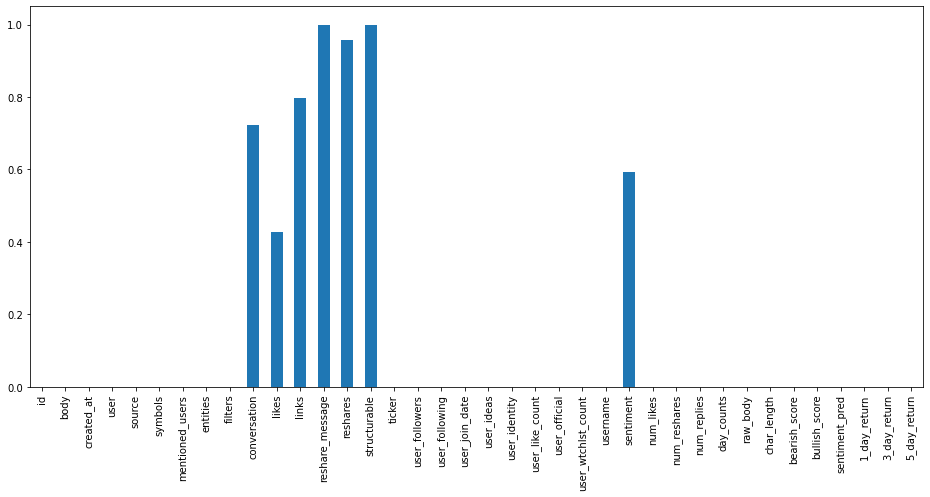

In [0]:
plt.figure(figsize=(16,7))
data.isna().mean().plot(kind='bar')

## Training data size

Number of unique ticker and date pairs:  1103


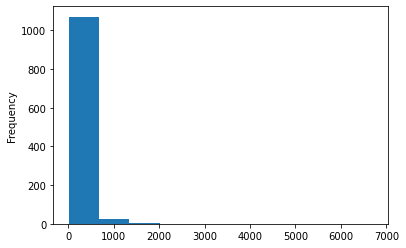

In [0]:
print('Number of unique ticker and date pairs: ', data.groupby(['created_at','ticker'])['id'].count().shape[0])
data.groupby(['created_at','ticker'])['id'].count().plot(kind='hist')

# Feature Engineering

In [0]:
data.columns

Index(['id', 'body', 'created_at', 'user', 'source', 'symbols',
       'mentioned_users', 'entities', 'filters', 'conversation', 'likes',
       'links', 'reshare_message', 'reshares', 'structurable', 'ticker',
       'user_followers', 'user_following', 'user_join_date', 'user_ideas',
       'user_identity', 'user_like_count', 'user_official',
       'user_wtchlst_count', 'username', 'sentiment', 'num_likes',
       'num_reshares', 'num_replies', 'day_counts', 'raw_body', 'char_length',
       'bearish_score', 'bullish_score', 'sentiment_pred', '1_day_return',
       '3_day_return', '5_day_return'],
      dtype='object')

In [0]:
id_cols = ['id', 'created_at', 'ticker']
feature_cols = ['num_likes','num_reshares', 'num_replies', 'bearish_score', 'bullish_score']
label_cols = ['1_day_return','3_day_return', '5_day_return', ]
maybe_cols = ['links','user_followers', 'user_following', 'user_join_date','user_identity', 'user_like_count', 'user_official',
              'user_wtchlst_count', 'user_like_count', 'day_counts']
irrelevant_cols = ['user', 'source', 'symbols','mentioned_users', 'entities', 'filters', 'conversation', 'likes', 'reshare_message','reshares',
                   'structurable', 'user_ideas','username', 'sentiment', 'raw_body', 'body','char_length','sentiment_pred']

In [0]:
identified_cols = set(id_cols + feature_cols + label_cols + maybe_cols + irrelevant_cols)
[col for col in data.columns if col not in identified_cols]

[]

In [0]:
data_group = data.loc[:, id_cols + feature_cols + label_cols].groupby(['created_at', 'ticker'])

In [0]:
labels_df = data_group[label_cols].mean()

feature_df_sum = data_group[feature_cols].sum()
feature_df_sum.columns = [f + '_sum' for f in feature_cols]

feature_df_mean = data_group[feature_cols].mean()
feature_df_mean.columns = [f + '_mean' for f in feature_cols]

feature_data = pd.concat([feature_df_sum, feature_df_mean, labels_df], axis=1)
feature_data.to_pickle(finpred_file)
feature_data.shape

(1103, 13)

# Predictive Modeling

In [18]:
feature_data = pd.read_pickle(finpred_file)
feature_data.head()

,,num_likes_sum,num_reshares_sum,num_replies_sum,bearish_score_sum,bullish_score_sum,num_likes_mean,num_reshares_mean,num_replies_mean,bearish_score_mean,bullish_score_mean,1_day_return,3_day_return,5_day_return
created_at,ticker,,,,,,,,,,,,,
2019-05-20,VIX,45,1,44,19.185993,34.814007,0.833333,0.018519,0.814815,0.355296,0.644704,-0.049601,0.002102,0.010929
2019-05-21,VIX,46,1,39,9.948185,20.051815,1.533333,0.033333,1.300000,0.331606,0.668394,-0.011057,0.033171,0.084918
2019-05-22,VIX,86,3,44,18.800280,33.199722,1.653846,0.057692,0.846154,0.361544,0.638456,0.066190,0.075581,0.074240
2019-05-23,VIX,103,4,78,33.612217,39.387783,1.410959,0.054795,1.068493,0.460441,0.539559,-0.020134,0.028943,0.051594
2019-05-24,VIX,48,2,58,11.992064,30.007936,1.142857,0.047619,1.380952,0.285525,0.714475,0.029538,0.028253,0.080051


In [28]:
sentiment_cols = ['bearish_score_mean', 'bearish_score_sum', 'bullish_score_mean','bullish_score_sum']
# in_cols = feature_df_sum.columns.union(feature_df_mean.columns)
in_cols = sentiment_cols
out_cols = label_cols[:]
X = feature_data.loc[:, in_cols]
y = feature_data[out_cols]
y_stratify = y.reset_index()['ticker']

xscaler = MinMaxScaler()
yscaler = MinMaxScaler((-1,1))
X.loc[:] = xscaler.fit_transform(X)
y.loc[:] = yscaler.fit_transform(y)


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y_stratify)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [29]:
in_cols

['bearish_score_mean',
 'bearish_score_sum',
 'bullish_score_mean',
 'bullish_score_sum']

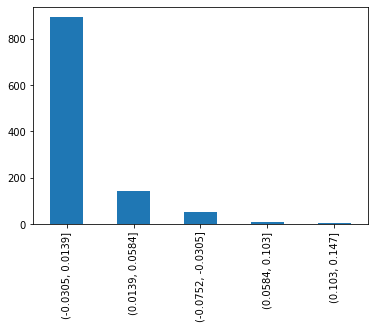

In [20]:
returns, bins = pd.cut(labels_df['1_day_return'], 5, retbins=True)
returns.value_counts().plot(kind='bar')

## Neural Network(Keras)

In [0]:
def build_model(input_dim, output_dim):
	# create model
  model = Sequential()
  model.add(Dense(3, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
  model.add(Dense(5, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
  model.add(Dense(output_dim, kernel_initializer='normal'))
	# Compile model
  optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model

In [31]:
model = build_model(X.shape[1], y_train.shape[1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 18        
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [0]:
filepath="weights-improvement-{val_loss:.2f}-{epoch:02d}.hdf5"
checkpoint      = ModelCheckpoint('/content/drive/My Drive/logs/finpred_5_/'+filepath, 
                                  monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
csv_logger      = CSVLogger("variant_filterer" +'.csv')
callbacks = [checkpoint,csv_logger]

In [33]:
history = model.fit(X_train, y_train, epochs=1000, verbose=1, callbacks=callbacks, validation_split=0.15)

Epoch 1/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.1112
Epoch 00001: val_loss improved from inf to 0.09733, saving model to /content/drive/My Drive/logs/finpred_5_/weights-improvement-0.10-01.hdf5
25/25 [==============================] - 0s 13ms/step - loss: 0.1137 - val_loss: 0.0973
Epoch 2/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.0824
Epoch 00002: val_loss improved from 0.09733 to 0.08216, saving model to /content/drive/My Drive/logs/finpred_5_/weights-improvement-0.08-02.hdf5
25/25 [==============================] - 0s 11ms/step - loss: 0.0980 - val_loss: 0.0822
Epoch 3/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.0710
Epoch 00003: val_loss improved from 0.08216 to 0.06604, saving model to /content/drive/My Drive/logs/finpred_5_/weights-improvement-0.07-03.hdf5
25/25 [==============================] - 0s 15ms/step - loss: 0.0806 - val_loss: 0.0660
Epoch 4/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.08

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [0]:
y_pred = yscaler.inverse_transform(model.predict(X_test)) 
y_pred_df = pd.DataFrame(y_pred*100, columns= out_cols)
y_test_df = pd.DataFrame(yscaler.inverse_transform(y_test)*100, columns= out_cols)

pd.concat([y_pred_df, y_test_df], axis=1)

,1_day_return,3_day_return,5_day_return,1_day_return,3_day_return,5_day_return
0,0.113509,0.284950,0.461296,2.971005,0.549524,1.608363
1,0.122420,0.304328,0.482929,-1.217247,-1.662439,-0.737565
2,-0.094424,-0.122508,-0.118221,-0.171429,-1.371429,-3.885714
3,0.334551,0.668192,0.990029,0.215850,0.370028,-1.171755
4,-0.024021,0.017168,0.075124,-1.773186,0.807304,2.162422
...,...,...,...,...,...,...
161,-0.149266,-0.222720,-0.283199,-2.725968,-3.873745,-7.986609
162,0.107616,0.246858,0.413186,0.356951,0.549641,0.353792
163,-0.173376,-0.269972,-0.350380,0.143821,0.092193,-0.667478
164,0.060553,0.181908,0.312488,1.013799,2.346757,2.816108


## Linear Regression

In [0]:
linreg = LinearRegression()
sc = MinMaxScaler()


pipe_linreg = Pipeline([('scaler', sc), ('clf', linreg)])
pipe_linreg.fit(X_train[['bearish_score', 'bullish_score']], y_train['3_day_return'])
pipe_linreg.score(X_train[['bearish_score', 'bullish_score']], y_train['3_day_return'])

0.0007906095944075764

In [0]:
sc = StandardScaler()
nn = MLPRegressor(hidden_layer_sizes=(5, 5, 3, 5, 5, 5), random_state=42)


col = ['5_day_return']

pipe_nn = Pipeline([('scaler', sc), ('clf', nn)])
pipe_nn.fit(X_train, y_train['5_day_return'])
pipe_nn.score(X_train, y_train['5_day_return'])

y_pred_train = pipe_nn.predict(X_train)
y_pred_test = pipe_nn.predict(X_test)
metrics.mean_squared_error()

-0.02616142847881719

In [0]:
pd.DataFrame({'y_pred': pipe_nn.predict(X_train), 
              'y_true': y_train['5_day_return']})*

,,y_pred,y_true
created_at,ticker,,
2019-08-23,DIA,1.813302,3.043427
2020-01-15,MSFT,1.519598,2.169384
2019-12-12,MSFT,1.256726,1.611851
2019-10-19,DIA,0.290459,0.969390
2019-09-20,VIX,0.340432,5.238345
...,...,...,...
2019-10-19,VIX,0.284142,-3.352941
2019-11-01,DIA,1.042885,1.364601
2019-12-28,TWTR,0.231327,1.592257


In [0]:
metrics.mean_squared_error

# Fetch Predictions

In [0]:
def predict(model, X_test, yscaler):
  y_pred = yscaler.inverse_transform(model.predict(X_test)) 
  y_pred_df = pd.DataFrame(y_pred*100, columns= out_cols)
  y_test_df = pd.DataFrame(yscaler.inverse_transform(y_test)*100, columns= out_cols)
  df = pd.concat([X_test.reset_index(), y_pred_df, y_test_df], axis=1)
  df.set_index(['created_at', 'ticker'])
  return df
  

In [0]:
model_path= Path('/content/drive/My Drive/logs/finpred_5_/weights-improvement-0.03-12.hdf5')
model = models.load_model(model_path)
predictions_file = Path('FinancialPrediction/predictions.pkl')
predict(model, X_test, yscaler).to_pickle(predictions_file)

In [0]:
predictions_df = pd.read_pickle(predictions_file)

In [0]:
def get_values(cols, ticker=None, rdate=None):
    if not ticker and not rdate:
      raise ValueError('at least one of ticker or rdate should be provided')
    df_filter = [True]*len(predictions_df)
    if ticker:
      df_filter = predictions_df['ticker'] == ticker
    if rdate:
      df_filter = (predictions_df['created_at'] == rdate) & df_filter
    df_subset = predictions_df.loc[df_filter, cols]
    return df_subset

In [0]:
cols = ['1_day_return', '3_day_return']
ticker='AAPL'
return_list = get_values(cols=cols, ticker=ticker, rdate=date(2020,1,13)).values.flatten().tolist()
col_names_str = ", ".join([c[:-6].replace('_', ' ').rstrip() for c in cols])
return_format = lambda r: str(math.ceil(r * 100) / 100.0) + '%'
returns_str = ', '.join([return_format(r) for r in return_list])
print(f'The {col_names_str} returns for {ticker} are {returns_str}')

The 1 day, 3 day returns for AAPL are -2.13%, -3.13%
